Inception网络是一种卷积神经网络架构，由Google团队提出，首次出现在2014年的论文“Going Deeper with Convolutions”中，其核心是Inception模块。以下是对Inception网络结构的简要介绍：
- **Inception模块的基本结构**：Inception模块通常包含多个分支，每个分支使用不同大小的卷积核（如1×1、3×3、5×5）或池化操作（如最大池化）。这些分支并行处理输入特征图，然后将各分支的输出沿通道方向拼接，形成最终的输出特征图。在Inception模块中，1×1卷积常被用作降维操作，以减少后续卷积操作的计算量。
- **Inception网络的版本演进**：
    - **Inception v1**：包含22层深的网络结构，引入了经典的Inception模块，通过1×1卷积进行降维，显著减少了计算复杂度。
    - **Inception v2**：在v1的基础上于卷积层与激活函数之间插入BN层（Batch Normalization），即Conv - BN - ReLU，并将v1结构中的5×5卷积核替换为2个3×3卷积核，进一步减少了参数量，加速了收敛并提高了稳定性。
    - **Inception v3**：引入了更深的因式分解卷积，如将3×3卷积分解为3×1和1×3卷积，进一步优化了计算效率。
    - **Inception v4**：结合多个改进模块，进一步提升了性能。
    - **Inception - ResNet**：将Inception模块与残差网络（ResNet）结构结合，利用残差连接加速训练并提高性能。
- **Inception网络的特点**：
    - **多尺度特征提取**：Inception模块可以在不同尺度上提取信息，从而增强模型对不同大小目标的适应能力。
    - **计算效率高**：通过1×1卷积和卷积因式分解，显著减少了参数量和计算成本。
    - **易于扩展**：Inception模块设计灵活，可结合其他架构进行改进。

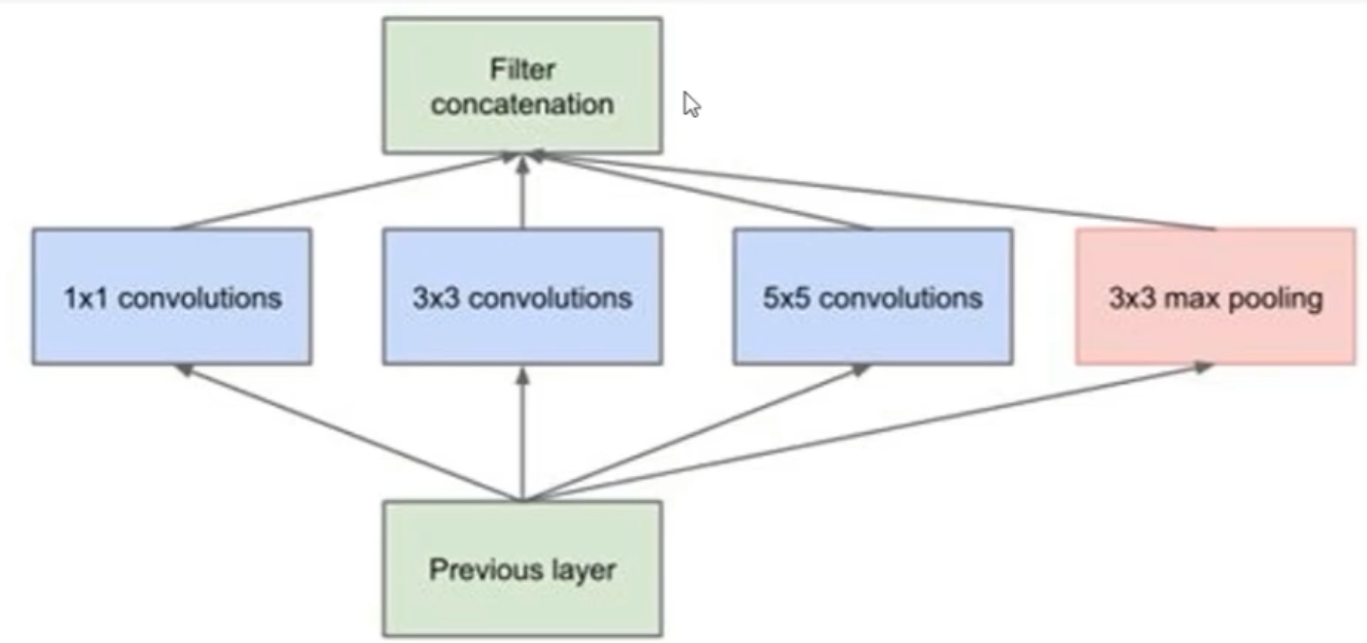

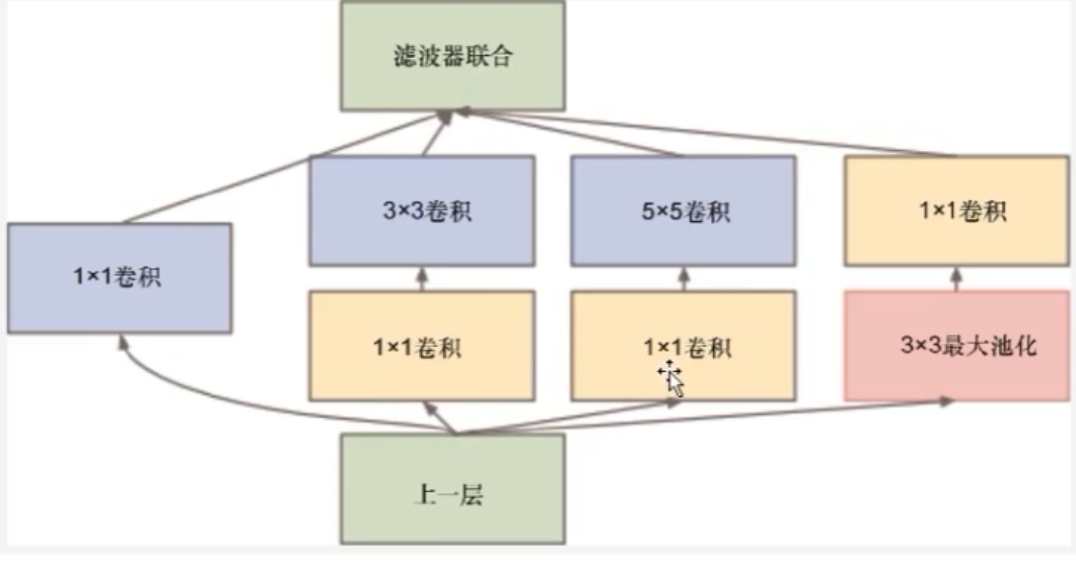 

In [1]:
import torch
from torch import nn 
import torch.nn.functional as F 
import torchvision

## 定义通用的卷积模型    

In [2]:
class Basic_Conv2d(nn.Module):
    def __init__(self,in_channels,output_channels,**kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,output_channels,bias=False,**kwargs)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self,x): 
        x = F.relu(self.bn(self.conv(x)),inplace=True) #直接就地改变,直接将源数据做更改
        return  x

    

In [3]:
class InceptionBlock(nn.Module): 
    def __init__(self,in_channels,pool_features):
        super().__init__() 
        
        self.branch1x1 = Basic_Conv2d(in_channels,output_channels=64,kernel_size=1)
       
        self.branch3x3_p1 = Basic_Conv2d(in_channels,output_channels=64,kernel_size=1)
        self.branch3x3_p2 = Basic_Conv2d(64,output_channels=96,kernel_size=3,padding=1)

        self.branch5x5_p1 = Basic_Conv2d(in_channels,output_channels=48,kernel_size=1)
        self.branch5x5_p2 = Basic_Conv2d(48,output_channels=64,kernel_size=5,padding=2)


        #注意定义的时候写的conv2d,但是这一步的确是1x1的卷积
        self.branch_pool1x1 = Basic_Conv2d(in_channels,pool_features,kernel_size=1)

        
    def forward(self,x): 
        b1x1_out = self.branch1x1(x)
        
        b3x3 = self.branch3x3_p1(x) 
        b3x3_out = self.branch3x3_p2(b3x3)

        b5x5 = self.branch5x5_p1(x) 
        b5x5_out = self.branch5x5_p2(b5x5)

        b_pool= F.max_pool2d(x,kernel_size=3,padding=1,stride=1) #指定滑动步幅为1,w_new = [w+2p-kernel_size]/s + 1 这样的话就保持大小不变
        b_pool_out = self.branch_pool1x1n(b_pool)

        out_puts = [b1x1_out,b3x3_out,b5x5_out,b_pool_out] 

        return torch.cat(out_puts,dim=1)

        
        
        
        
        
        

In [4]:
myinceptionblock = InceptionBlock(32,64)

In [5]:
myinceptionblock

InceptionBlock(
  (branch1x1): Basic_Conv2d(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch3x3_p1): Basic_Conv2d(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch3x3_p2): Basic_Conv2d(
    (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch5x5_p1): Basic_Conv2d(
    (conv): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch5x5_p2): Basic_Conv2d(
    (conv): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1

这段代码实现了GoogLeNet中的Inception模块，它通过并行多个不同尺寸的卷积操作来捕获不同尺度的特征，是深度学习中的经典架构创新。下面我来详细解释代码中的各个部分：

### 1. 基础卷积模块 (Basic_Conv2d)
```python
class Basic_Conv2d(nn.Module):
    def __init__(self,in_channels,output_channels,**kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,output_channels,bias=False,**kwargs)
        self.bn = nn.BatchNorm2d(output_channels)

    def forward(self,x): 
        x = F.relu(self.bn(self.conv(x)),inplace=True)
        return x
```
- 这是一个基础的卷积块，包含一个卷积层和一个BatchNorm层，最后使用ReLU激活函数
- 卷积层不使用偏置(bias=False)，因为后面的BatchNorm会消除偏置的影响
- inplace=True参数会直接在输入上修改激活结果，节省内存但可能影响梯度计算(在训练时需谨慎使用)

### 2. Inception模块结构设计
```python
class InceptionBlock(nn.Module): 
    def __init__(self,in_channels,pool_features):
        super().__init__() 
        
        # 分支1: 1x1卷积
        self.branch1x1 = Basic_Conv2d(in_channels,output_channels=64,kernel_size=1)
       
        # 分支2: 1x1卷积 + 3x3卷积
        self.branch3x3_p1 = Basic_Conv2d(in_channels,output_channels=64,kernel_size=1)
        self.branch3x3_p2 = Basic_Conv2d(64,output_channels=96,kernel_size=3,padding=1)

        # 分支3: 1x1卷积 + 5x5卷积
        self.branch5x5_p1 = Basic_Conv2d(in_channels,output_channels=48,kernel_size=1)
        self.branch5x5_p2 = Basic_Conv2d(48,output_channels=64,kernel_size=5,padding=2)

        # 分支4: 最大池化 + 1x1卷积
        self.branch_pool1x1 = Basic_Conv2d(in_channels,pool_features,kernel_size=1)
```
- Inception模块的核心思想是"多尺度特征融合"
- 每个分支使用不同尺寸的卷积核来捕获不同尺度的信息
- 1x1卷积的作用:
  - 降低通道数，减少参数量和计算量(如在3x3和5x5卷积前)
  - 增加模型的非线性表达能力
- 5x5卷积通过padding=2保持特征图尺寸不变
- pool_features参数控制池化分支输出的通道数

### 3. 前向传播实现
```python
def forward(self,x): 
    b1x1_out = self.branch1x1(x)
    
    b3x3 = self.branch3x3_p1(x) 
    b3x3_out = self.branch3x3_p2(b3x3)

    b5x5 = self.branch5x5_p1(x) 
    b5x5_out = self.branch5x5_p2(b5x5)

    b_pool= F.max_pool2d(x,kernel_size=3,padding=1,stride=1) 
    b_pool_out = self.branch_pool1x1(b_pool)

    out_puts = [b1x1_out,b3x3_out,b5x5_out,b_pool_out] 

    return torch.cat(out_puts,dim=1)
```
- 各分支并行处理输入特征图
- 池化分支使用3x3最大池化，padding=1和stride=1确保特征图尺寸不变
- 最后将所有分支的输出在通道维度(dim=1)上拼接
- 输出通道数计算: 64(1x1) + 96(3x3) + 64(5x5) + pool_features

### 4. 实例化与参数计算
```python
myinceptionblock = InceptionBlock(32,64)
```
- 这个实例的输入通道数为32，池化分支输出通道数为64
- 总输出通道数为: 64 + 96 + 64 + 64 = 288
- 参数量分析:
  - 1x1卷积分支: (32×64×1×1 + 64)×2 = 4160
  - 3x3卷积分支: (32×64×1×1 + 64) + (64×96×3×3 + 96) = 56448
  - 5x5卷积分支: (32×48×1×1 + 48) + (48×64×5×5 + 64) = 77248
  - 池化分支: (32×64×1×1 + 64) = 2048
  - 总参数量: 4160 + 56448 + 77248 + 2048 = 140904

### 5. 架构优势
- **计算效率**: 通过1x1卷积降维，减少了大卷积核的计算负担
- **特征融合**: 同时捕获不同尺度的空间特征
- **网络深度**: 增加了网络深度但没有显著增加参数量
- **稀疏性**: 模拟了神经网络的稀疏连接，提高性能

### 6. 潜在问题与改进
- 原论文中使用了更复杂的分支结构
- 5x5卷积计算量仍然较大，实际应用中常使用两个3x3卷积替代
- 代码中存在一个小错误: `self.branch_pool1x1n` 应改为 `self.branch_pool1x1`

这种Inception结构是GoogLeNet(Inception v1)的核心组件，后续又发展出了Inception v2、v3、v4等改进版本，主要在计算效率和性能上进行了优化。

# inception的大量$1\times1$的卷积的作用 

在Inception结构中，1×1卷积（也称为“点卷积”）起到了**降低维度、减少参数量、增加模型非线性表达能力**的关键作用。以下是详细解释：


### 1. **降维（减少通道数）**
Inception模块通过并行多个不同尺寸的卷积操作（如1×1、3×3、5×5卷积）来捕获多尺度特征，但直接拼接这些输出会导致**通道数激增**，使模型参数量和计算量爆炸式增长。  
**1×1卷积的作用**：  
- 在3×3和5×5卷积前，先用1×1卷积**减少输入通道数**，从而降低后续大卷积核的计算负担。  
- 例如：输入为192通道，若直接用3×3卷积，参数量为 `192×3×3×输出通道数`；若先用1×1卷积将通道数降至96，则参数量变为 `192×1×1×96 + 96×3×3×输出通道数`，大幅减少计算量。

#### 示例计算：
假设输入为28×28×192的特征图，输出通道数为128：
- **直接3×3卷积**：参数量 = `192×3×3×128 = 221,184`  
- **1×1降维后**（先降至96通道）：参数量 = `192×1×1×96 + 96×3×3×128 = 18,432 + 110,592 = 129,024`（减少约42%）


### 2. **增加模型非线性**
1×1卷积本质上是对每个像素的通道进行线性变换（加权求和），配合ReLU激活函数后，能引入额外的非线性，增强模型的表达能力。  
- 即使不改变通道数，1×1卷积 + ReLU也能让模型学习更复杂的特征组合。


### 3. **跨通道信息整合**
1×1卷积可以在不改变空间尺寸的情况下，对不同通道的信息进行整合。  
- 例如：将RGB三通道图像通过1×1卷积映射到更高维空间，使每个输出通道包含原始三个通道的混合信息。


### 4. **替代全连接层**
在GoogLeNet中，1×1卷积还被用于**替代传统的全连接层**，大幅减少参数量。  
- 例如：在网络末尾使用全局平均池化 + 1×1卷积，替代全连接层进行分类，参数量从数百万降至数千。


### 代码示例（对比有无1×1卷积的参数量）
```python
import torch
import torch.nn as nn

# 无1×1降维的3×3卷积
conv_direct = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1)
params_direct = sum(p.numel() for p in conv_direct.parameters())
print(f"直接3×3卷积参数量: {params_direct}")  # 221,184

# 有1×1降维的结构
conv_1x1 = nn.Conv2d(in_channels=192, out_channels=96, kernel_size=1)
conv_3x3 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding=1)
params_reduced = sum(p.numel() for p in conv_1x1.parameters()) + sum(p.numel() for p in conv_3x3.parameters())
print(f"1×1+3×3卷积参数量: {params_reduced}")  # 129,024
```


### 总结：1×1卷积在Inception中的价值
| 作用               | 具体效果                                                                 |
|--------------------|--------------------------------------------------------------------------|
| **降维**           | 减少通道数，降低后续卷积的计算量和参数量。                               |
| **增加非线性**     | 通过ReLU激活函数增强模型表达能力。                                       |
| **跨通道信息融合** | 在不改变空间尺寸的情况下整合多通道特征。                                 |
| **模型优化**       | 是Inception结构高效性的核心，使网络能在保持性能的同时控制复杂度。       |

这种“**先降维再卷积**”的设计思想也被后续网络（如ResNet、MobileNet）广泛采用，成为深度学习中的经典优化手段。

# 直接使用预训练 

## 1.导入   

In [7]:
inception = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.IMAGENET1K_V1)

In [8]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri